# Experiment 4: Non Linear Regression

In [255]:
import pickle

import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import rcParams
rcParams['agg.path.chunksize'] = 10000

from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

import seaborn as sns
from mpl_toolkits import mplot3d

from mpl_toolkits.mplot3d import Axes3D

In [256]:
df = pd.read_csv("../../data/energy/df.csv", )
df.head()

,dom_id,pmt_id,pos_x,pos_y,pos_z,dir_x,dir_y,dir_z,tot,time,energy,label,group
0,1054,32658,-16.064,-76.599,112.441,0.000,0.955,-0.296,35,28449.0,13.415,1,1
1,1054,32671,-16.208,-76.707,112.611,-0.719,0.415,0.558,24,28450.0,13.415,1,1
2,1053,32639,-16.064,-76.624,122.011,0.000,0.830,0.558,12,28450.0,13.415,1,1
3,1054,32670,-16.064,-76.624,112.611,0.000,0.830,0.558,54,28450.0,13.415,1,1
4,1054,32664,-15.968,-76.625,112.559,0.478,0.827,0.296,47,28451.0,13.415,1,1


# HoldOut Set

In [257]:
np.random.seed(20)
remove_n = 50
group_names = df.group.unique()

drop_groups = np.random.choice(group_names, remove_n, replace=False)
hold_df = df[df.group.isin(drop_groups)]

df = df.drop(drop_groups)

# Define target and predictors

In [258]:
y = df['energy']

X = df[['pos_x', 'pos_y', 'pos_z', 'time']]

# Train/Test Split

In [259]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.34, random_state=40)

print(" X TRAIN SHAPE: {} \n X TEST SHAPE: {} \n".format(X_train.shape, X_test.shape))
print(" Y TRAIN SHAPE: {} \n Y TEST SHAPE: {}".format(y_train.shape, y_test.shape))

 X TRAIN SHAPE: (323304, 4) 
 X TEST SHAPE: (166552, 4) 

 Y TRAIN SHAPE: (323304,) 
 Y TEST SHAPE: (166552,)


# Plots

In [175]:
train = pd.concat([X_train, y_train], axis=1)
train['bins'] = pd.cut(train['energy'], bins=10)

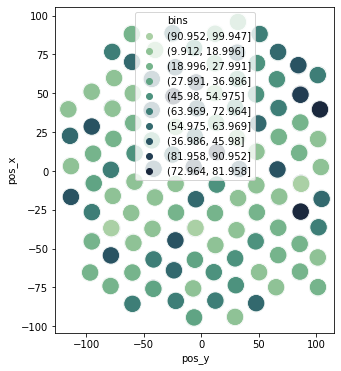

In [178]:
sns.scatterplot("pos_y", "pos_x",
                hue="bins",
                s=300,
                palette="ch:r=-.5,l=.75", 
                data=train)

# rcParams['figure.figsize'] = 17, 17

# plt.savefig("../../assets/energy/energy_train", dpi=600, bbox_inches = "tight")

In [ ]:
test = pd.concat([X_test, y_test], axis=1)
test['bins'] = pd.cut(test['energy'], bins=10)

sns.scatterplot("pos_y",
                "pos_x",
                "bins",
                s=300,
                palette="ch:r=-.5,l=.75",
                data=test)

# rcParams['figure.figsize'] = 17,17
# plt.savefig("../../assets/energy/energy_test", dpi=600, bbox_inches = "tight")

In [ ]:
# energy vs group

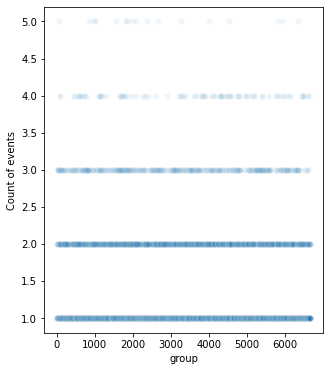

In [179]:
e_groups = df.groupby('group')['energy'].nunique().to_frame().reset_index()
sns.scatterplot(x='group', y='energy',
                alpha=0.07,
                data=e_groups)
plt.ylabel("Count of events")


plt.savefig("../../assets/energy/energy_groups", dpi=600, bbox_inches = "tight")

# Model 1: Decision Tree

In [260]:
dtree = DecisionTreeRegressor(max_depth=20,
                              min_samples_leaf=1,
                              random_state=3)

dtree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=20, random_state=3)

## Model 1: Results

In [261]:
pred_train_tree = dtree.predict(X_train)
print("MSE: ", mean_squared_error(y_train, pred_train_tree))
print("R2: ", r2_score(y_train, pred_train_tree))

pred_test_tree = dtree.predict(X_test)
print("MSE: %.2f" % mean_squared_error(y_test, pred_test_tree))
print("R2: ", r2_score(y_test, pred_test_tree))

MSE:  87.89872532680842
R2:  0.8514985202344028
MSE: 105.12
R2:  0.8217167216930455


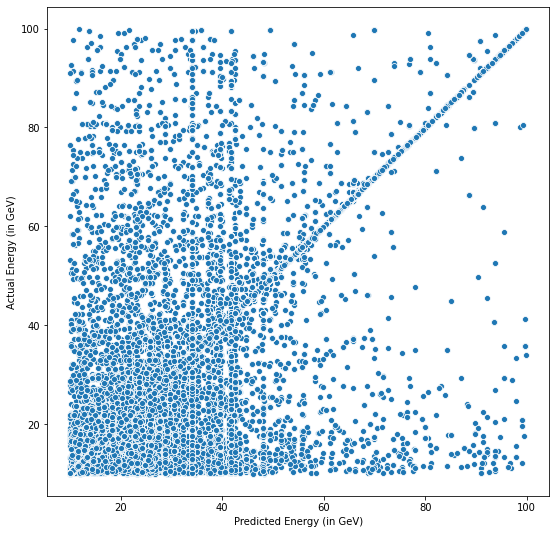

In [262]:
sns.scatterplot(pred_test_tree, y_test)
plt.xlabel("Predicted Energy (in GeV)")
plt.ylabel("Actual Energy (in GeV)")
rcParams['figure.figsize'] = 9, 9
plt.savefig("../../assets/energy/results_dt.png", dpi=400,bbox_inches="tight")

## Save Model

In [263]:
filename = 'dtree_model.sav'
pickle.dump(dtree, open(filename, 'wb'))

## Test on Unseen Data

In [264]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.8217167216930455


In [265]:
Xnew = hold_df[['pos_x',
               'pos_y',
               'pos_z',
               'time']]
hold_y = hold_df['energy']

ynew = loaded_model.predict(Xnew)

In [266]:
print("MSE: ", mean_squared_error(hold_y, ynew))
print("R2: ", r2_score(hold_y, ynew))

MSE:  43.13744589621369
R2:  0.911283471670212


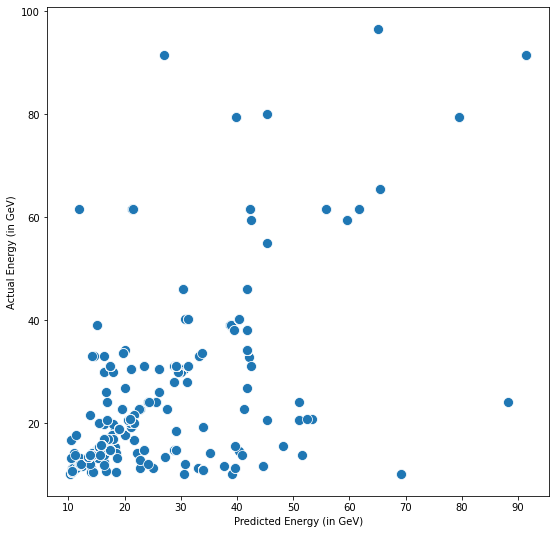

In [267]:
sns.scatterplot(ynew, hold_y,
               s=100)
plt.xlabel("Predicted Energy (in GeV)")
plt.ylabel("Actual Energy (in GeV)")
rcParams['figure.figsize'] = 9, 9
plt.savefig("../../assets/energy/results_eval_dt.png", dpi=400,bbox_inches="tight")

# Model2: Random Forest (Bootstrap Aggregation)

In [268]:
model_rf = RandomForestRegressor(n_estimators=30,
                                 oob_score=True,
                                 random_state=100,
                                 verbose=2)

model_rf.fit(X_train, y_train) 

pred_train_rf = model_rf.predict(X_train)

print("MSE: ", mean_squared_error(y_train,pred_train_rf))
print("R2: ", r2_score(y_train, pred_train_rf))

pred_test_rf = model_rf.predict(X_test)
print("MSE: ", mean_squared_error(y_test,pred_test_rf))
print("R2: ", r2_score(y_test, pred_test_rf))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 30


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


building tree 2 of 30
building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   49.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


MSE:  2.576023179978393
R2:  0.9956479089689302
MSE:  16.64784454466188
R2:  0.9717652233668683


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.3s finished


## Model2: Results

In [269]:
model_rf.score(X_test, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.7s finished


0.9717652233668683

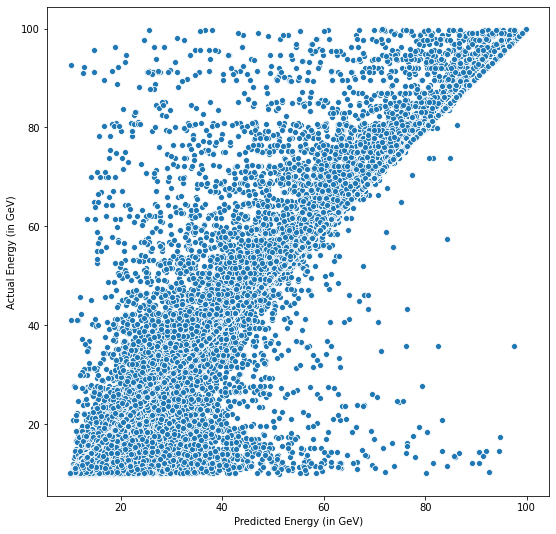

In [276]:
sns.scatterplot(pred_test_rf, y_test)
plt.xlabel("Predicted Energy (in GeV)")
plt.ylabel("Actual Energy (in GeV)")
rcParams['figure.figsize'] = 9, 9
plt.savefig("../../assets/energy/results_rf.png", dpi=400,bbox_inches="tight")

## Save Model

In [271]:
filename = 'rf_model.sav'
pickle.dump(model_rf, open(filename, 'wb'))

## Unseen Data

In [272]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


0.9717652233668683


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.4s finished


In [273]:
Xnew = hold_df[['pos_x',
               'pos_y',
               'pos_z',
               'time']]
hold_y = hold_df['energy']

ynew = loaded_model.predict(Xnew)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished


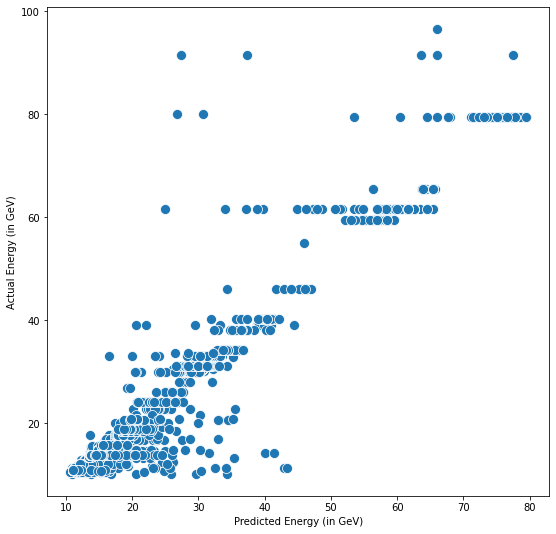

In [280]:
sns.scatterplot(ynew, hold_y,
               s=100)
plt.xlabel('Predicted Energy (in GeV)')
plt.ylabel('Actual Energy (in GeV)')
rcParams['figure.figsize'] = 9, 9
plt.savefig("../../assets/energy/results__eval_rf.png", dpi=400,bbox_inches="tight")

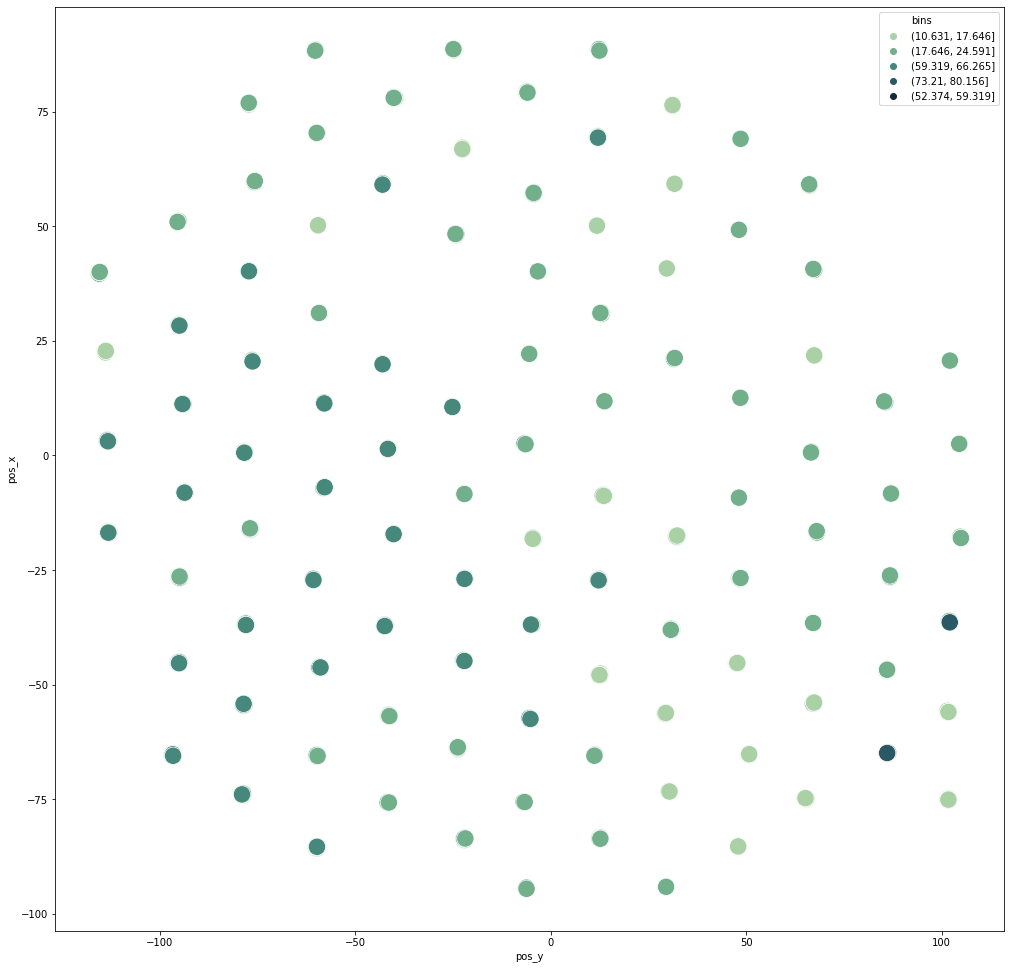

In [92]:
hold_df['bins'] = pd.cut(hold_df['energy'], bins=10)

sns.scatterplot("pos_y",
                "pos_x",
                "bins",
                s=300,
                palette="ch:r=-.5,l=.75",
                data=hold_df)

rcParams['figure.figsize'] = 17,17
plt.savefig("../../assets/energy/energy_hold", dpi=600, bbox_inches = "tight")

In [219]:
np.unique(hold_y)

array([10.015, 10.046, 10.067, 10.089, 10.095, 10.179, 10.27 , 10.514,
       10.596, 10.693, 10.7  , 10.889, 11.027, 11.269, 11.311, 11.388,
       11.594, 11.716, 11.731, 11.782, 11.922, 12.025, 12.138, 12.18 ,
       12.593, 12.676, 12.822, 13.069, 13.372, 13.492, 13.549, 13.804,
       13.807, 13.957, 14.054, 14.056, 14.206, 14.252, 14.289, 14.324,
       14.374, 14.517, 14.52 , 14.636, 14.66 , 14.761, 14.827, 14.885,
       15.196, 15.51 , 15.553, 15.768, 15.776, 16.193, 16.47 , 16.706,
       16.727, 16.822, 16.912, 17.067, 17.074, 17.655, 17.747, 17.789,
       17.838, 18.489, 18.68 , 18.823, 19.012, 19.323, 19.529, 19.562,
       19.643, 19.83 , 19.906, 19.936, 20.107, 20.651, 20.806, 20.923,
       21.357, 21.472, 21.691, 22.236, 22.616, 22.789, 23.374, 24.1  ,
       24.152, 24.19 , 24.249, 24.42 , 25.211, 26.176, 26.887, 27.27 ,
       27.507, 27.522, 27.607, 28.04 , 28.064, 28.693, 29.361, 29.405,
       30.054, 30.122, 30.173, 30.597, 31.214, 32.342, 32.804, 33.183,
      

In [275]:
print('Mean squared error: %.2f'
      % mean_squared_error(hold_y, ynew, squared=False))

print('Coefficient of determination: %.2f'
      % r2_score(hold_y, ynew))

Mean squared error: 2.78
Coefficient of determination: 0.98


In [221]:
R2 = r2_score(hold_y, ynew)
n=1035
p = 3

In [222]:
1-(1-R2)*(n-1)/(n-p-1)

0.9917126952320167